### **Develop a Face Recognition System Using FaceNet in Keras**

**Face recognition** is a computer vision task of identifying and verifying a person based on a photograph of their face.

**FaceNet** is a face recognition system developed in 2015 by researchers at Google that achieved then state-of-the-art results on a range of face recognition benchmark datasets. The FaceNet system can be used broadly thanks to multiple third-party open source implementations of the model and the availability of pre-trained models.

In [2]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 5.1 MB/s 


In [3]:
# importing all the required packages  
import numpy as np
from PIL import Image
from mtcnn.mtcnn import MTCNN
from os import listdir
import matplotlib.pyplot as plt
from numpy import savez_compressed

from numpy import expand_dims

from numpy import savez_compressed
from keras.models import load_model
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from random import choice
from sklearn.svm import SVC

The model can be downloaded from here:

https://drive.google.com/drive/folders/1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn

Loading the keras Facenet model

In [28]:
# load the model
model = load_model('model/facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


We can then use the PIL library to resize this small image of the face to the required size; specifically, *the model expects square input faces with the shape 160×160.*

The function extract_face() will load a image from the loaded filename and return the extracted face. It assumes that the photo contains one face and will return the first face detected.

In [29]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	image = image.convert('RGB')
 
	# convert to array
	pixels = np.asarray(image)
 
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
 
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height

	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
  
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = np.asarray(image)
	return face_array

## FACE CLASSIFICATION SYSTEM

The model will be trained and tested using the ‘5 Celebrity Faces Dataset‘ that contains many photographs of five different celebrities.      
Dataset : https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset

We will use an MTCNN model for face detection, the FaceNet model will be used to create a face embedding for each detected face, then we will develop a Linear Support Vector Machine (SVM) classifier model to predict the identity of a given face.



1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


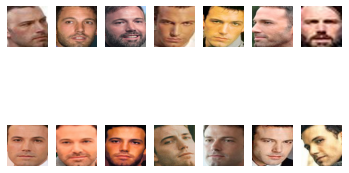

In [30]:
# specify folder to plot
folder = '/train/ben_afflek/'
i = 1
# enumerate files
for filename in listdir(folder):
	# path
	path = folder + filename
	# get face
	face = extract_face(path)
	print(i, face.shape)
	# plot
	plt.subplot(2, 7, i)
	plt.axis('off')
	plt.imshow(face)
	i += 1
plt.show()

The load_faces() function below will load all of the faces into a list for a given directory, e.g. ‘5-celebrity-faces-dataset/train/ben_afflek/‘.

In [31]:
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

The load_dataset() function below takes a directory name such as ‘5-celebrity-faces-dataset/train/‘ and detects faces for each subdirectory (celebrity), assigning labels to each detected face.

In [32]:
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
	
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return np.asarray(X), np.asarray(y)

In [33]:
# load train dataset
trainX, trainy = load_dataset('train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('val/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 17 examples for class: elton_john
>loaded 22 examples for class: mindy_kaling
>loaded 21 examples for class: jerry_seinfeld
>loaded 14 examples for class: ben_afflek
>loaded 19 examples for class: madonna
(93, 160, 160, 3) (93,)
>loaded 5 examples for class: mindy_kaling
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: madonna
(25, 160, 160, 3) (25,)


Split the dataset into training and testing

In [34]:
# load the face dataset
data = np.load('5-celebrity-faces-dataset.npz')

trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [35]:
# calculate a face embedding for each face in the dataset using facenet
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

(93, 128)
(25, 128)


In [36]:
newTrainX

array([[-1.2797478 , -0.5859505 , -1.789598  , ..., -2.1503055 ,
         1.5229194 ,  0.670077  ],
       [-0.72027767, -0.3146742 , -0.03435355, ..., -0.94301856,
         1.0244118 ,  1.4725418 ],
       [-0.18011072, -0.23416513, -0.23938525, ..., -0.8595734 ,
         0.51362085, -0.32467905],
       ...,
       [ 0.75499547,  1.5800099 ,  1.9619987 , ..., -0.7991954 ,
         0.09471634, -0.6231384 ],
       [-1.3169055 , -0.20699431, -0.0393372 , ..., -1.0607537 ,
         1.8123893 , -1.0895754 ],
       [-0.18910527, -0.12672013, -0.33319628, ..., -0.91556627,
        -0.30337352, -0.4735623 ]], dtype=float32)

In [37]:
# load dataset
data = np.load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

Dataset: train=93, test=25


In [38]:
trainX.shape

(93, 128)

First, it is a good practice to normalize the face embedding vectors. It is a good practice because the vectors are often compared to each other using a distance metric.

In [39]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

In [40]:
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

Next, we can fit a model.

It is common to use a Linear Support Vector Machine (SVM) when working with normalized face embedding inputs. This is because the method is very effective at separating the face embedding vectors. 

In [41]:
# fit model
model = SVC(kernel='linear')
model.fit(trainX, trainy)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [42]:
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=100.000, test=100.000


Predicted: elton_john (92.361)
Expected: elton_john


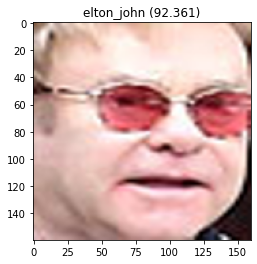

In [50]:
# develop a classifier for the 5 Celebrity Faces Dataset

# load faces
data = np.load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']


# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

# plot for fun
plt.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()